## Check recording info

In [1]:
import numpy as np
import subjects

sess = subjects.nsd.ratJday2[0]
print(sess.recinfo)


filename: /data/Clustering/sessions/RatJ/Day2/RatJ_Day2_2019-06-02_03-59-19.xml 
# channels: 67
sampling rate: 30000
lfp Srate (downsampled): 1250



## Set probe configuration
Lets create probe configuration for a 128-channel probe

In [ ]:
from neuropy.core import Shank, Probe, ProbeGroup
from neuropy.plotting import plot_probe

shanks = []
channel_groups = sess.recinfo.channel_groups
for i in range(8):
    shank = Shank.auto_generate(
        columns=2,
        contacts_per_column=8,
        xpitch=15,
        ypitch=20,
        y_shift_per_column=[0, -7.5],
        channel_id=np.append(
            channel_groups[i][::2][::-1], channel_groups[i][1::2][::-1]
        ),
    )
    shanks.append(shank)
    shank.set_disconnected_channels(sess.recinfo.skipped_channels)

probe1 = Probe(shanks)

probe2 = Probe(shanks)
probe2.move((probe1.x_max + 500, 0))

prbgrp = ProbeGroup()
prbgrp.add_probe(probe1)
prbgrp.add_probe(probe2)

# prbgrp.filename = sess.filePrefix.with_suffix(".probegroup.npy")
# prbgrp.save()
plot_probe(prbgrp)

## Create epochs for your experimental paradigm
A typical experiment involves multiple epochs such pre sleep, running on track and then another sleep epoch.

In [ ]:
import pandas as pd
from neuropy.core import Epoch

epochs = pd.DataFrame(
    {
        "start": [0, 10000, 20000],
        "stop": [9000, 13600, 30000],
        "label": ["pre", "maze", "post"],
    }
)

a = Epoch(epochs=epochs)
a.filename = sess.filePrefix.with_suffix(".paradigm.npy")
a.save()

# Detect epochs
Here we will various types of epochs which typical for hippocampal recordings.

## Artifacts epochs
A typical session will have some artifacts that may negatively influence many analyses. Using a simple zscore measure, we can identify epochs where signal is above some threshold.

/data/Clustering/sessions/RatJ/Day2/RatJ_Day2_2019-06-02_03-59-19.artifact.npy saved


<Axes: xlabel='Time (s)', ylabel='Absolute zscore'>

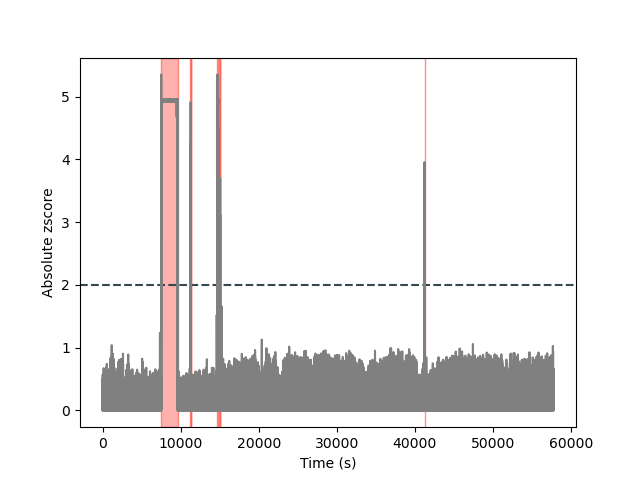

In [6]:
from neuropy.analyses import detect_artifact_epochs
from neuropy import plotting

signal = sess.eegfile.get_signal([9])
artifact_epochs = detect_artifact_epochs(signal, thresh=2, edge_cutoff=1)
artifact_epochs = artifact_epochs.from_array(
    artifact_epochs.starts - 0.5, artifact_epochs.stops + 0.5, "artifact"
)
artifact_epochs.metadata = dict(threshold=2)
artifact_epochs.save(sess.filePrefix.with_suffix(".artifact.npy"))
plotting.plot_artifact_epochs(artifact_epochs, signal)


## Ripple epochs
To detect ripples one also needs probegroup.

In [ ]:
from neuropy.analyses import oscillations

signal = sess.eegfile.get_signal()
ripple_epochs = oscillations.detect_ripple_epochs(signal, sess.probegroup)
ripple_epochs.filename = sess.filePrefix.with_suffix(".ripple.npy")
ripple_epochs.save()

In [ ]:
signal = sess.eegfile.get_signal(channel_id=[1, 2, 3, 4], t_start=1, t_stop=1.2)
plotting.plot_signal_traces(signal)


# Neurons
- import spiketrains from Phy
- estimate neuron types such pyramidal, interneuron etc. 

## Importing spiketrains from Phy

In [7]:
from neuropy.io import PhyIO
from neuropy.core import Neurons
from pathlib import Path
import numpy as np

cluster_path = Path(
    "/data/Clustering/sessions/RatJ/Day2/spykcirc/RatJ_Day2_2019-06-02_03-59-19/RatJ_Day2_2019-06-02_03-59-19.GUI"
)

chan_grps = sess.recinfo.channel_groups
phy_data = PhyIO(cluster_path)
spiketrains = phy_data.spiketrains
peak_chans = phy_data.peak_channels
waveforms = phy_data.waveforms
shank_id = sess.probegroup.get_shank_id_for_channels(peak_chans)


neuron_type_id = phy_data.cluster_info.q.values
neuron_type = np.ones(len(neuron_type_id), dtype="U5")
neuron_type[neuron_type_id < 4] = "pyr"
neuron_type[neuron_type_id == 6] = "mua"
neuron_type[neuron_type_id == 8] = "inter"

neurons = Neurons(
    np.array(spiketrains, dtype=object),
    t_stop=sess.eegfile.duration,
    sampling_rate=phy_data.sampling_rate,
    peak_channels=peak_chans,
    waveforms=waveforms,
    shank_ids=np.array(shank_id).astype(int),
    neuron_type=neuron_type,
)

neurons.filename = sess.filePrefix.with_suffix(".neurons")
neurons.save()

RatJ_Day2_2019-06-02_03-59-19.neurons saved


In [11]:
sess.neurons.firing_rate


array([ 8.02179204,  7.05624525,  0.47734392, 10.53951189,  1.93280815,
        0.2938327 ,  5.72069718,  0.79260011,  1.39938559,  0.1094209 ,
        0.0985273 ,  0.40493354,  0.03711443,  3.93826915,  7.63859375,
       23.0796528 , 11.61629807,  0.41722996,  0.27563052,  0.12225422,
        0.29225668,  0.11537861,  0.04483867,  0.20955886,  0.48683468,
        4.48759048,  0.35070801,  0.467628  ,  0.06951812,  0.59376166,
        0.17301595,  0.26842585,  0.21362881,  0.07928599])

<AxesSubplot:xlabel='Time (s)', ylabel='Units'>

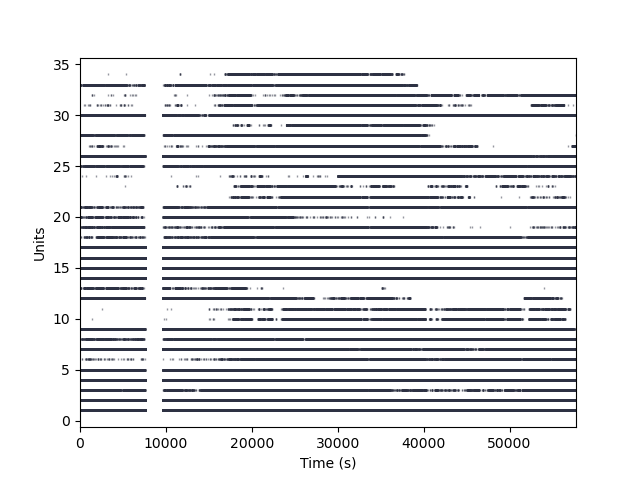

In [8]:
%matplotlib widget
from neuropy.plotting import plot_raster

plot_raster(neurons)

## Estimate neuron type

In [ ]:
%matplotlib widget
from neuropy.utils import neurons_util
neuron_type = neurons_util.estimate_neuron_type(sess.neurons)
sess.neurons.neuron_type = neuron_type

In [7]:
neurons.filename = sess.filePrefix.with_suffix(".neurons")
neurons.save()

AttributeError: 'ProcessData' object has no attribute 'neurons'

In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt
from neuropy.plotting import plot_raster

plot_raster(neurons,color='jet',add_vert_jitter=True)

## BinnedSpiketrain and Mua objects using Neurons

In [ ]:
mua = sess.neurons.get_mua()
mua.filename = sess.filePrefix.with_suffix(".mua.npy")
mua.save()

In [ ]:
%matplotlib widget
from neuropy import plotting
smth_mua = sess.mua.get_smoothed(sigma=0.02)
plotting.plot_mua(smth_mua)

In [ ]:
from neuropy.analyses import detect_pbe_epochs

pbe = detect_pbe_epochs(smth_mua)
pbe.filename = sess.filePrefix.with_suffix(".pbe")
pbe.save()

# Assign position data

In [ ]:
from neuropy.io import OptitrackIO
from neuropy.core import Position
from pathlib import Path

opti_folder = sess.filePrefix.parent / "position"
opti_data = OptitrackIO(dirname=opti_folder)

In [ ]:
import pandas as pd
from datetime import datetime

# ---- startimes of concatenated .dat files
tracking_sRate = opti_data.sampling_rate
rec_datetime = pd.read_csv(sess.filePrefix.with_suffix(".datetime.csv"))
data_time = []
for i, file_time in enumerate(rec_datetime["StartTime"]):
    tbegin = datetime.strptime(file_time, "%Y-%m-%d_%H-%M-%S")
    nframes = rec_datetime["nFrames"][i]
    duration = pd.Timedelta(nframes / sess.recinfo.dat_sampling_rate, unit="sec")
    tend = tbegin + duration
    trange = pd.date_range(
        start=tbegin,
        end=tend,
        periods=int(duration.total_seconds() * tracking_sRate),
    )
    data_time.extend(trange)
data_time = pd.to_datetime(data_time)

# ------- deleting intervals that were deleted from .dat file after concatenating
ndeletedintervals = rec_datetime.count()["deletedStart (minutes)"]
for i in range(ndeletedintervals):
    tnoisy_begin = data_time[0] + pd.Timedelta(
        rec_datetime["deletedStart (minutes)"][i], unit="m"
    )
    tnoisy_end = data_time[0] + pd.Timedelta(
        rec_datetime["deletedEnd (minutes)"][i], unit="m"
    )

    del_index = np.where((data_time > tnoisy_begin) & (data_time < tnoisy_end))[0]

    data_time = np.delete(data_time, del_index)

x, y, z = opti_data.get_position_at_datetimes(data_time)
traces = np.vstack((z, x, y))

position = Position(traces=traces, t_start=0, sampling_rate=opti_data.sampling_rate)

In [ ]:
position.filename = sess.filePrefix.with_suffix(".position.npy")
position.save()

In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt

# plt.plot(opti_data.datetime_array,opti_data.z)
plt.plot(position.x,position.y)

In [ ]:
%matplotlib widget
from neuropy.utils import signal_process

signal = sess.eegfile.get_signal([40])

spec = signal_process.spectrogramBands(signal.traces[0])


In [ ]:
%matplotlib widget

import matplotlib.pyplot as plt

plt.plot(spec.time+0.25,spec.theta/500)
plt.plot(sess.position.time,sess.position.y)
plt.plot(sess.position.time[1:],np.diff(sess.position.y)*100)
plt.xlim([12500,12600])
plt.ylim([-400,400])

## Linearize position

In [ ]:
from neuropy.utils import position_util

maze = sess.paradigm["maze"]
maze_pos = sess.position.time_slice(maze[0], maze[1])
linear_pos = position_util.linearize_position(maze_pos)

In [ ]:
linear_pos.y


In [ ]:
%matplotlib widget
plt.plot(maze_pos.time,maze_pos.x)
plt.plot(linear_pos.time,linear_pos.x)

In [ ]:
import numpy as np

a = np.ones(5)
np.vstack((a, a, a)).shape

In [ ]:
from neuropy.core import animal

d = {"name": "hello", "tag": "ser"}

an = animal.Animal(d)

In [ ]:
import time

time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(4917008))

In [ ]:
4917000 / 30000